In [1]:
# Analysis of loss of the Y chromosome in TCGA UVM 
# include NA cases in WT group (as before, by gene epression)
# 7-23-20
# Esther Rheinbay

import sys
import pandas as pd
import numpy as np
import re
import warnings

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import CoxPHFitter

from scipy.stats import ttest_ind, spearmanr, norm, ks_2samp, mannwhitneyu, fisher_exact
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


/Users/esther/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
workdir = '/Users/esther/Documents/Projects/2019/chrY/UVM/'
palette = {'wt_male':'lightgrey', 'LOY':'cornflowerblue', 'wt_female':'lightgrey', 'LOX':'deeppink', 'NA':'white'}
Y_palette = {'wt':'lightgrey', 'LOY':'cornflowerblue', 'NA':'white'}
status_palette =  {'WT':'lightgrey', 'LOX':'mediumvioletred', 't0LOY':'darkslateblue', 'rLOY':'cornflowerblue', 'pLOY':'skyblue', 'pLOX':'mistyrose', 'Gain_Loss':'lightgoldenrodyellow', 'Gain':'lightcoral'}
Y_status_colors =  ['lightgrey', 'darkslateblue', 'cornflowerblue', 'skyblue', 'lightgoldenrodyellow', 'lightcoral']


In [3]:
fig_dir = '/Users/esther/Documents/Projects/2019/chrY/Manuscript/Plots_Figures/'

<h3> SEER incidence </h3>

/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/2363524899.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(seer_eye_adult['Age at Diagnosis'], rotation=45)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/2363524899.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seer_eye_adult['M_F_ratio'] = seer_eye_adult.Male/seer_eye_adult.Female


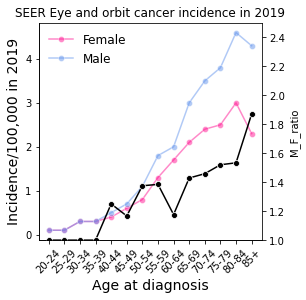

In [4]:
# SEER incidence in males and females in 2019
# from https://seer.cancer.gov/statistics-network/explorer/application.html?site=75&data_type=1&graph_type=2&compareBy=sex&chk_sex_3=3&chk_sex_2=2&hdn_rate_type=1&race=1&age_range=62&stage=101&advopt_precision=1&advopt_show_ci=on&advopt_display=1
seer_eye = pd.read_excel('/Users/esther/Documents/Projects/2019/chrY/SEER_eye_and_orbit_2019.xlsx', sheet_name=2, header = 0)
seer_eye_adult = seer_eye.iloc[5:19]


# Figure 5A
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
p= sns.lineplot(x = 'Age at Diagnosis', y = 'value', hue='variable',  data=pd.melt(seer_eye_adult, 'Age at Diagnosis' ), marker='o', palette=['deeppink','cornflowerblue' ], legend=False, alpha = 0.5)
plt.legend(title='', loc='upper left', labels=['Female', 'Male'], frameon=False, fontsize=12)
ax.set_ylabel('Incidence/100,000 in 2019', fontsize=14)
ax.set_xlabel('Age at diagnosis', fontsize=14)
ax.set_xticklabels(seer_eye_adult['Age at Diagnosis'], rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
seer_eye_adult['M_F_ratio'] = seer_eye_adult.Male/seer_eye_adult.Female
ax2 = plt.twinx()
p= sns.lineplot(x = 'Age at Diagnosis', y = 'M_F_ratio', data=seer_eye_adult, marker='o', color = 'black', legend=False, ax=ax2)
ax2.set_ylim(1,2.5)
ax.set_title('SEER Eye and orbit cancer incidence in 2019')
plt.savefig(fig_dir + "SEER_incidence.pdf")
plt.savefig(fig_dir + "SEER_incidence.png")

<h3> Load TCGA Y status calls and other data files </h3>

In [5]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
males = TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values
females = TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values
TCGA_survival = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)

# TCGA sample type codes from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
TCGA_sample_type_codes = {'01': 'TP', '02':'TR', '03':'TB', '04':'TRBM', '05':'TAP', '06':'TM', '07':'TAM', '08':'THOC', '09':'TBM', '10':'NB', '11':'NT', '12':'NBC', '13':'NEBV', '14':'NBM', '15':'15SH', '16':'16SH', '20':'CELLC', '40':'TRB', '50':'CELL', '60':'XP', '61':'XCL', '99':'99SH'}


In [6]:
# chrY genes
chrY_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
par_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/PAR_genes/chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/3600142502.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  chrY_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/3600142502.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  par_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/PAR_genes/chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)


In [7]:
# 7 gene signature for assessing chrY expression
expressed_Y_genes = ['RPS4Y1', 'DDX3Y', 'ZFY','KDM5D', 'UTY', 'EIF1AY' , 'USP9Y' ]

In [8]:
# Detailed UVM data from supplementary table of the marker paper
UVM_clinical = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/TCGA_UVM_TableS1.xlsx', header=0, index_col=0,  sheet_name="Summary_by_Case", skiprows=[0,2,3])
UVM_subtypes = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/TCGA_UVM_TableS1.xlsx',  header=1, index_col=0,  sheet_name="Molecular-Clinical_Data")


In [9]:
# Load exome-based sex chromosome status
WEX_calls = pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/TCGA_WEX/table.LOX_LOY.t3.filter.10408.20220726.tsv', sep='\t', header=0, index_col=1)
WEX_calls = pd.read_excel('/Users/esther/Documents/Projects/2019/chrY/TCGA_WEX/Supplementary_tables.xlsx', sheet_name='Supp_Table_1', header=0, index_col=0)

LOY_cases = WEX_calls[(WEX_calls.Gender=='male') & (WEX_calls.Y_status=='LOY')].index
wtY_cases = WEX_calls[(WEX_calls.Gender=='male') & (WEX_calls.Y_status=='WT')].index

TCGA_sample_info['LOY_status'] = TCGA_sample_info.apply(lambda x: WEX_calls.loc[x.name].Y_status if x.name in WEX_calls.index else np.nan, axis=1)

In [10]:
# One case has Y gain by WEX, here considered "wt" with respect to LOY
UVM_clinical['Y_status'] = UVM_clinical.apply(lambda x: 'LOY' if (x.name in males and x.name in LOY_cases) else ('wt_male' if x.name in males else 'NA'), axis=1)
UVM_subtypes['Y_status'] = UVM_subtypes.apply(lambda x: 'LOY' if (x.name in males and x.name in LOY_cases) else ('wt_male' if x.name in males else 'NA'), axis=1)


<h3> Association with age of diagnosis </h3>

Median LOY age at diagnosis: 68.0
Median wt age at diagnosis: 58.0


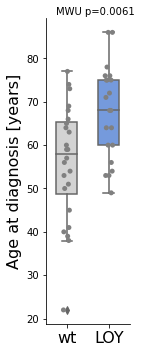

In [11]:
# Figure 5B
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'Y_status', y = 'Age at Diagnosis' , data=UVM_clinical[UVM_clinical.Gender=='Male'], orient='v', width=0.5, palette=palette, order = ['wt_male', 'LOY'])
sns.stripplot(x = 'Y_status', y = 'Age at Diagnosis' , data=UVM_clinical[UVM_clinical.Gender=='Male'], color = 'grey', order = ['wt_male', 'LOY'])
ax.set_xlabel('sex chromosome _status')
ax.text(x= -0.25, y=90, s='MWU p=' + str(round(mannwhitneyu(UVM_clinical[UVM_clinical.Y_status=='LOY']['Age at Diagnosis'], UVM_clinical[UVM_clinical.Y_status=='wt_male']['Age at Diagnosis']).pvalue,4)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
ax.set_ylabel('Age at diagnosis [years]', fontsize=16)
print('Median LOY age at diagnosis:', round(np.nanmedian(UVM_clinical[UVM_clinical.Y_status=='LOY']['Age at Diagnosis']),0))
print('Median wt age at diagnosis:', round(np.nanmedian(UVM_clinical[UVM_clinical.Y_status=='wt_male']['Age at Diagnosis']),0))
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_age_at_diagnosis_boxplot.pdf')


In [12]:
# IQR for age difference between LOY and wt
print("LOY:", UVM_subtypes[UVM_subtypes.Y_status=='LOY']['Age at Diagnosis'].describe())
print("wt:", UVM_subtypes[UVM_subtypes.Y_status=='wt_male']['Age at Diagnosis'].describe())

LOY: count    21.000000
mean     67.571429
std      10.851596
min      49.000000
25%      60.000000
50%      68.000000
75%      75.000000
max      86.000000
Name: Age at Diagnosis, dtype: float64
wt: count    24.000000
mean     55.958333
std      13.417961
min      22.000000
25%      48.750000
50%      58.000000
75%      65.250000
max      77.000000
Name: Age at Diagnosis, dtype: float64


<h3> Association with distant metastasis</h3>

Distant Metastasis  No  Yes
Y_status                   
LOY                 10   11
wt_male             19    5
LOY/metastasis Fisher p: (0.23923444976076555, 0.034518151920673264)
52.38095238095239 % of LOY cases metastasized vs 20.833333333333336 % of wt cases


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/733228515.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.fraction = df.Yes/(df.Yes+df.No)*100


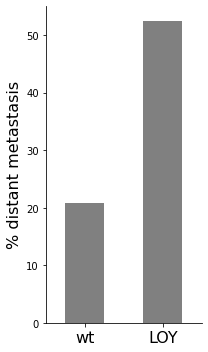

In [13]:
# Figure 5D
df = UVM_clinical[UVM_clinical.Gender=='Male'].groupby('Y_status')['Distant Metastasis'].value_counts().unstack().loc[['LOY', 'wt_male']]
print(df)
met_fisher = fisher_exact(df)
print('LOY/metastasis Fisher p:', met_fisher)
print(11/21*100, '% of LOY cases metastasized vs', 5/24*100, '% of wt cases' )
df.fraction = df.Yes/(df.Yes+df.No)*100
plt.figure(figsize=(3,5)) 
df.fraction[['wt_male', 'LOY']].plot(kind='bar', color='grey')
plt.gca().spines['right'].set_visible(False)
#plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% distant metastasis', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('')
plt.xticks([0,1], labels=['wt', 'LOY'], rotation = 0, fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_distant_met_barplot.pdf')

<h3> Independent validation data from Laurent et al, 2011 (PMID: 21135111) </h3>

In [14]:
# Affy arrays for 63 patients (39 male, female), GEO Accession: GSE22138
# the GEO series matrix file contains age, sex and survival information
Laurent_meta_data = pd.read_csv(workdir + '/Laurent_et_al_validation_expression/GSE22138_series_matrix.txt', sep='\t', skiprows=46, index_col=0, skipfooter= 54764-67).transpose()

/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/682953489.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  Laurent_meta_data = pd.read_csv(workdir + '/Laurent_et_al_validation_expression/GSE22138_series_matrix.txt', sep='\t', skiprows=46, index_col=0, skipfooter= 54764-67).transpose()


In [15]:
cols = Laurent_meta_data.iloc[0,Laurent_meta_data.columns.values=="!Sample_characteristics_ch1"]
colnames = list(map(lambda x: x.split(':')[0], cols))

Laurent_meta_data.columns.values[Laurent_meta_data.columns.values=="!Sample_characteristics_ch1"]=colnames
for c in colnames:

    Laurent_meta_data[c]= Laurent_meta_data.apply(lambda x: x[c].split(':')[1].strip(), axis=1)

# Inspect data frame
Laurent_meta_data.head()

!Sample_geo_accession,!Sample_status,!Sample_submission_date,!Sample_last_update_date,!Sample_type,!Sample_channel_count,!Sample_source_name_ch1,!Sample_organism_ch1,tissue,age,gender,eye,tumor location,tumor diameter (mm),tumor thickness (mm),tumor cell type,retinal detachment,extrascleral extension,chromosome 3 status,months to endpoint,metastasis
GSM550623,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),76.54,female,right,NA,NA,12.2,mixed,no,NA,NA,73,no
GSM550624,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),67.57,male,left,on equator,10,11.3,epithelioid,NA,NA,NA,32.13,yes
GSM550625,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),61.82,male,right,on equator,20,10.9,NA,yes,NA,NA,0.39,yes
GSM550626,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),46.4,male,right,posterior to equator,15,14,mixed,yes,yes,disomy,64,yes
GSM550627,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),84.99,male,right,anterior to equator,20,7,NA,no,NA,monosomy,67.81,no


In [16]:
# list of housekeeping genes to normalize Y expression to total expression (does not contain Y genes)
housekeeping = pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/tirosh_house_keeping.txt', sep='\t', header=None, skiprows=2)
housekeeping.columns = ['gene']

# replace HPRT with HPRT1, its human gene name
housekeeping[housekeeping.gene=='HPRT']='HPRT1'

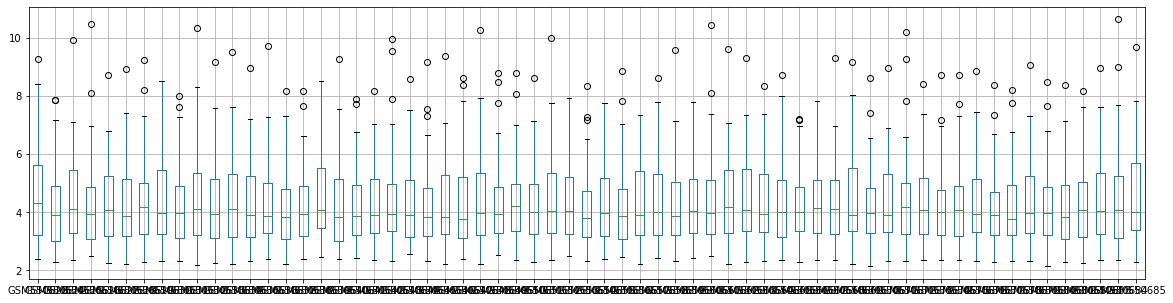

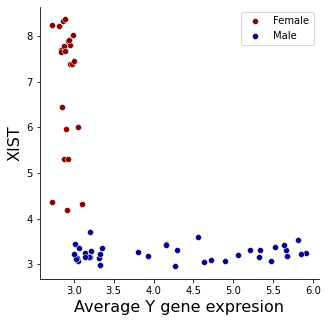

In [17]:
# chrY gene expression signatures for Laurent dataset
Laurent_exp = pd.read_csv(workdir + '/Laurent_et_al_validation_expression/GSE22138_RAW/data.ann.txt', sep='\t', index_col=0, header=0)
Laurent_exp.columns.values[4:67] = list(map(lambda x: x.split(".")[0], Laurent_exp.columns.values[4:67]))

# remove cross-mapping probes ("_x_at")
Laurent_exp=Laurent_exp[~Laurent_exp["Row.names"].str.endswith("_x_at")]

# More or less normalized? Check distributions
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
Laurent_exp[4:67].boxplot()

# calculate average Y score
Laurent_avg_Y = Laurent_exp[Laurent_exp.SYMBOL.isin(expressed_Y_genes)][Laurent_exp.columns.values[4:67]].apply(lambda x: np.nanmean(x), axis=0)
Laurent_meta_data['avg_Y_exp'] = Laurent_meta_data.apply(lambda x: Laurent_avg_Y[x.name], axis=1)

# housekeeping normalization 
Laurent_avg_housekeeping_tumor = Laurent_exp[Laurent_exp.SYMBOL.isin(housekeeping.gene)][Laurent_exp.columns.values[4:67]].apply(lambda x: np.nanmean(x), axis=0)
Laurent_ratio_Y_housekeeping_tumor = Laurent_avg_Y/Laurent_avg_housekeeping_tumor
Laurent_meta_data['ratio_Y_housekeeping_tumor'] = Laurent_meta_data.apply(lambda x: Laurent_ratio_Y_housekeeping_tumor[x.name], axis=1)
Laurent_meta_data["Y_status"] = Laurent_meta_data.apply(lambda x: 'fLOY' if x.ratio_Y_housekeeping_tumor<0.5 else 'wt_male', axis=1)
# add XIST expression
Laurent_XIST = Laurent_exp[Laurent_exp.SYMBOL=="XIST"][Laurent_exp.columns.values[4:67]].apply(lambda x: np.nanmean(x), axis=0)
Laurent_meta_data['XIST'] = Laurent_meta_data.apply(lambda x: Laurent_XIST[x.name], axis=1)

# check chrY average expression vs XIST
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x = "avg_Y_exp", y = "XIST", data = Laurent_meta_data[Laurent_meta_data.gender=='female'], color='darkred', ax=ax)
sns.scatterplot(x = "avg_Y_exp", y = "XIST", data = Laurent_meta_data[Laurent_meta_data.gender=='male'], color='darkblue', ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('XIST', fontsize=16)
ax.set_xlabel('Average Y gene expresion', fontsize=16)
ax.legend(['Female', 'Male'])


wt_male    20
fLOY       19
Name: Y_status, dtype: int64
Fraction of male samples with LOY: 0.48717948717948717


/Users/esther/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/2031092365.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laurent_males["Y_status"] = Laurent_males.apply(lambda x: 'fLOY' if x.avg_Y_exp<4 else 'wt_male', axis=1)


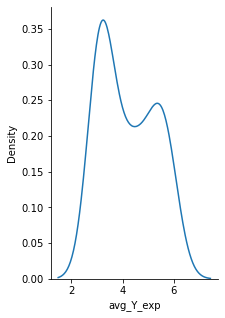

In [18]:
# Supplementary Figure 5A
# Classify male patients into fLOY and with Y based on above plot (fLOY cutoff <3.5)
Laurent_males = Laurent_meta_data[Laurent_meta_data.gender=='male']
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.distplot(Laurent_males.avg_Y_exp, hist=False)
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'Laurent_chrY_dist.pdf')
Laurent_males["Y_status"] = Laurent_males.apply(lambda x: 'fLOY' if x.avg_Y_exp<4 else 'wt_male', axis=1)
print(Laurent_males.Y_status.value_counts())
print ('Fraction of male samples with LOY:',float(Laurent_males.Y_status.value_counts()['fLOY'])/float(Laurent_males.shape[0]))

/Users/esther/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/642756295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laurent_males["Y_status"] = Laurent_males.apply(lambda x: 'fLOY' if x.ratio_Y_housekeeping_tumor<0.5 else 'wt_male', axis=1)


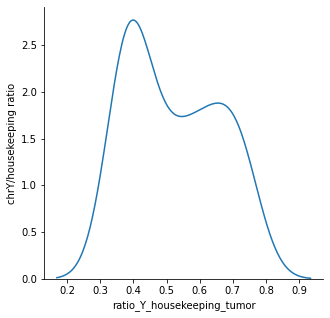

In [19]:
# Classify male patients into fLOY and with Y based on above plot, using Y/housekeeping ratio. Same results.
Laurent_males = Laurent_meta_data[Laurent_meta_data.gender=='male']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.distplot(Laurent_males.ratio_Y_housekeeping_tumor, hist=False)
ax.set_ylabel('chrY/housekeeping ratio')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Laurent_males["Y_status"] = Laurent_males.apply(lambda x: 'fLOY' if x.ratio_Y_housekeeping_tumor<0.5 else 'wt_male', axis=1)


49% of males in Laurent cohort have LOY, consistent with 47% in TCGA UVM. 

/Users/esther/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/esther/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/esther/opt/anaconda3/lib/python3.9/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_l

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.00 0.05      4.46

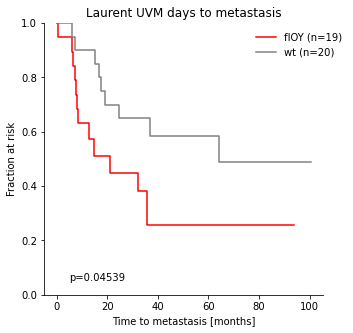

In [20]:
# Figure 5C
# endpoint is metastasis-free survival
MFS_time = Laurent_males['months to endpoint']
metastasis = Laurent_males['metastasis']
metastasis = metastasis.apply(lambda x: 1 if x=='yes' else 0)

# Split (male) patients into low_Y and other
Laurent_low_Y = Laurent_males[Laurent_males.Y_status=='fLOY'].index.values
Laurent_other = Laurent_males[Laurent_males.Y_status=='wt_male'].index.values

# Kaplan-Meier analysis
kmf = KaplanMeierFitter() 
fig, ax = plt.subplots(1,1, figsize=(5,5))
k1 = kmf.fit(MFS_time[Laurent_low_Y], metastasis[Laurent_low_Y],label='flOY (n=' + str(len(Laurent_low_Y)) + ')' )
ax = k1.plot(ci_show=False, color="red") 
ax.set_ylabel('Fraction at risk')

k2 = kmf.fit(MFS_time[Laurent_other].dropna(), metastasis[Laurent_other].dropna(),label='wt (n=' + str(len(Laurent_other)) + ')' )
k2.plot(ax=ax, color='grey', ci_show=False)
test = logrank_test(MFS_time[Laurent_low_Y].astype(float), MFS_time[Laurent_other].astype(float), metastasis[Laurent_low_Y], metastasis[Laurent_other], alpha=.99)
test.print_summary()
ax.set_ylim([0,1])
ax.text(5, 0.05, "p=" + str(round(test.p_value,5)))
ax.set_xlabel('Time to metastasis [months]')
ax.set_title('Laurent UVM days to metastasis')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0), frameon=False)
plt.savefig(fig_dir + 'Laurent_KM_males.pdf')

In [21]:
# Does the association of LOY with age at diagnosis hold?
Laurent_males['age'] = pd.to_numeric(Laurent_males['age'])
print('Median LOY age at diagnosis:', round(np.nanmedian(Laurent_males[Laurent_males.Y_status=='fLOY']['age']),0))
print('Median wt age at diagnosis:', round(np.nanmedian(Laurent_males[Laurent_males.Y_status=='wt_male']['age']),0))

#print(Laurent_males[Laurent_males.Y_status=='fLOY']['age'].describe())
#print(Laurent_males[Laurent_males.Y_status=='wt_male']['age'].describe())


Median LOY age at diagnosis: 68.0
Median wt age at diagnosis: 60.0


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/4230272237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laurent_males['age'] = pd.to_numeric(Laurent_males['age'])


metastasis  no  yes
Y_status           
fLOY         6   13
wt_male     11    9
68.42105263157895 % of fLOY cases metastasized vs 45.0 % of wt cases


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_22203/23801819.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.fraction = df.yes/(df.yes+df.no)*100


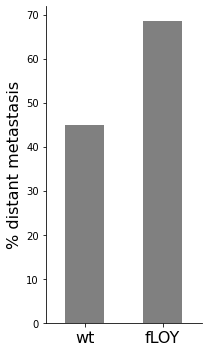

In [22]:
# Supplementary Figure 5B - association of LOY with metastasis
df = Laurent_males.groupby('Y_status').metastasis.value_counts().unstack()
Laurent_metastasis_status = Laurent_males.metastasis
Laurent_met_fisher = fisher_exact(df)
print(df)
print(13/19*100, '% of fLOY cases metastasized vs', 9/20*100, '% of wt cases')

met_fisher = fisher_exact(df)
df.fraction = df.yes/(df.yes+df.no)*100
plt.figure(figsize=(3,5)) 
df.fraction[['wt_male', 'fLOY']].plot(kind='bar', color='grey')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% distant metastasis', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('')
plt.xticks([0,1], labels=['wt', 'fLOY'], rotation = 0, fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_Laurent_distant_met_barplot.pdf')

<h3> EMT and subclonal fraction </h3>

In [23]:
# EMT scores from Gibbons & Creighton, 2016, PMID: 28073171
# Higher score = more EMT (scores is the sum of mesenchymal markers- epithelial markers)
EMT_scores = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/Creighton_EMT_scores/NIHMS840944-supplement-Supp_Datafile_S1.xlsx', sheet_name=0, skiprows=2, header=0, index_col=1)
EMT_scores['sample_id'] = EMT_scores.apply(lambda x: x.name[0:12], axis=1)
EMT_scores['LOY_status'] = EMT_scores.apply(lambda x: TCGA_sample_info.loc[x.sample_id].LOY_status if x.sample_id in TCGA_sample_info.index else 'NA', axis=1)
EMT_scores['gender'] = EMT_scores.apply(lambda x: TCGA_sample_info.loc[x.sample_id].gender if x.sample_id in TCGA_sample_info.index else 'NA', axis=1)

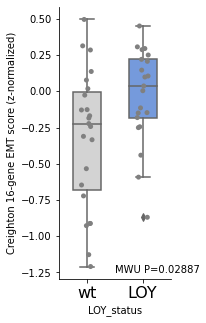

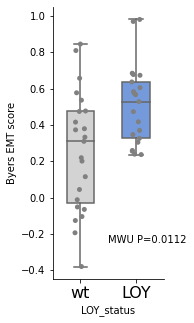

In [24]:
# Figure 5E
# EMT scores for males only
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'LOY_status', y = 'Creighton 16-gene EMT score (z-normalized)', data = EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], order = ['WT', 'LOY'], palette=['lightgrey', 'cornflowerblue'], width=0.5) 
sns.stripplot(x = 'LOY_status', y = 'Creighton 16-gene EMT score (z-normalized)' , data=EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], color = 'grey', order = ['WT', 'LOY'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
ax.text(0.5, -1.25, 'MWU P=' + str(round(mannwhitneyu(EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='WT')]['Creighton 16-gene EMT score (z-normalized)'], EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='LOY')]['Creighton 16-gene EMT score (z-normalized)'])[1],5)))
plt.savefig(fig_dir + 'UVM_EMT_Creighton.pdf')
# Byers score - even better!

fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'LOY_status', y = 'Byers EMT score (z-normalized)', data = EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], order = ['WT', 'LOY'], palette=['lightgrey', 'cornflowerblue'], width=0.5) 
sns.stripplot(x = 'LOY_status', y = 'Byers EMT score (z-normalized)' , data=EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], color = 'grey', order = ['WT', 'LOY'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.5, -.25, 'MWU P=' + str(round(mannwhitneyu(EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='WT')]['Byers EMT score (z-normalized)'], EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='LOY')]['Byers EMT score (z-normalized)'])[1],4)))
ax.set_ylabel('Byers EMT score')
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
plt.savefig(fig_dir + 'UVM_EMT_Byers.pdf')

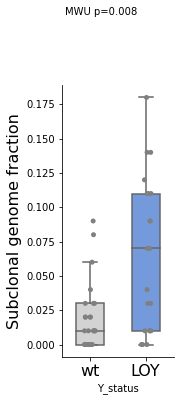

In [25]:
# Figure 5F
# subclonal genome fraction
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'Y_status', y = 'Subclonal genome fraction'  , data=UVM_subtypes, orient='v', order=[ "wt_male", "LOY"], width=0.5, palette=palette, fliersize=0)
sns.stripplot(x = 'Y_status', y = 'Subclonal genome fraction'  , data=UVM_subtypes, orient='v', order=[ "wt_male", "LOY"], color='grey')
ax.text(x=-0.45, y=0.24, s='MWU p=' + str(round(mannwhitneyu(UVM_subtypes[UVM_subtypes.Y_status=='LOY']['Subclonal genome fraction' ], UVM_subtypes[UVM_subtypes.Y_status=='wt_male']['Subclonal genome fraction' ]).pvalue,3)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
ax.set_ylabel('Subclonal genome fraction', fontsize=16)
plt.savefig(fig_dir + 'UVM_subclonal_genome_fraction_boxplot.pdf')

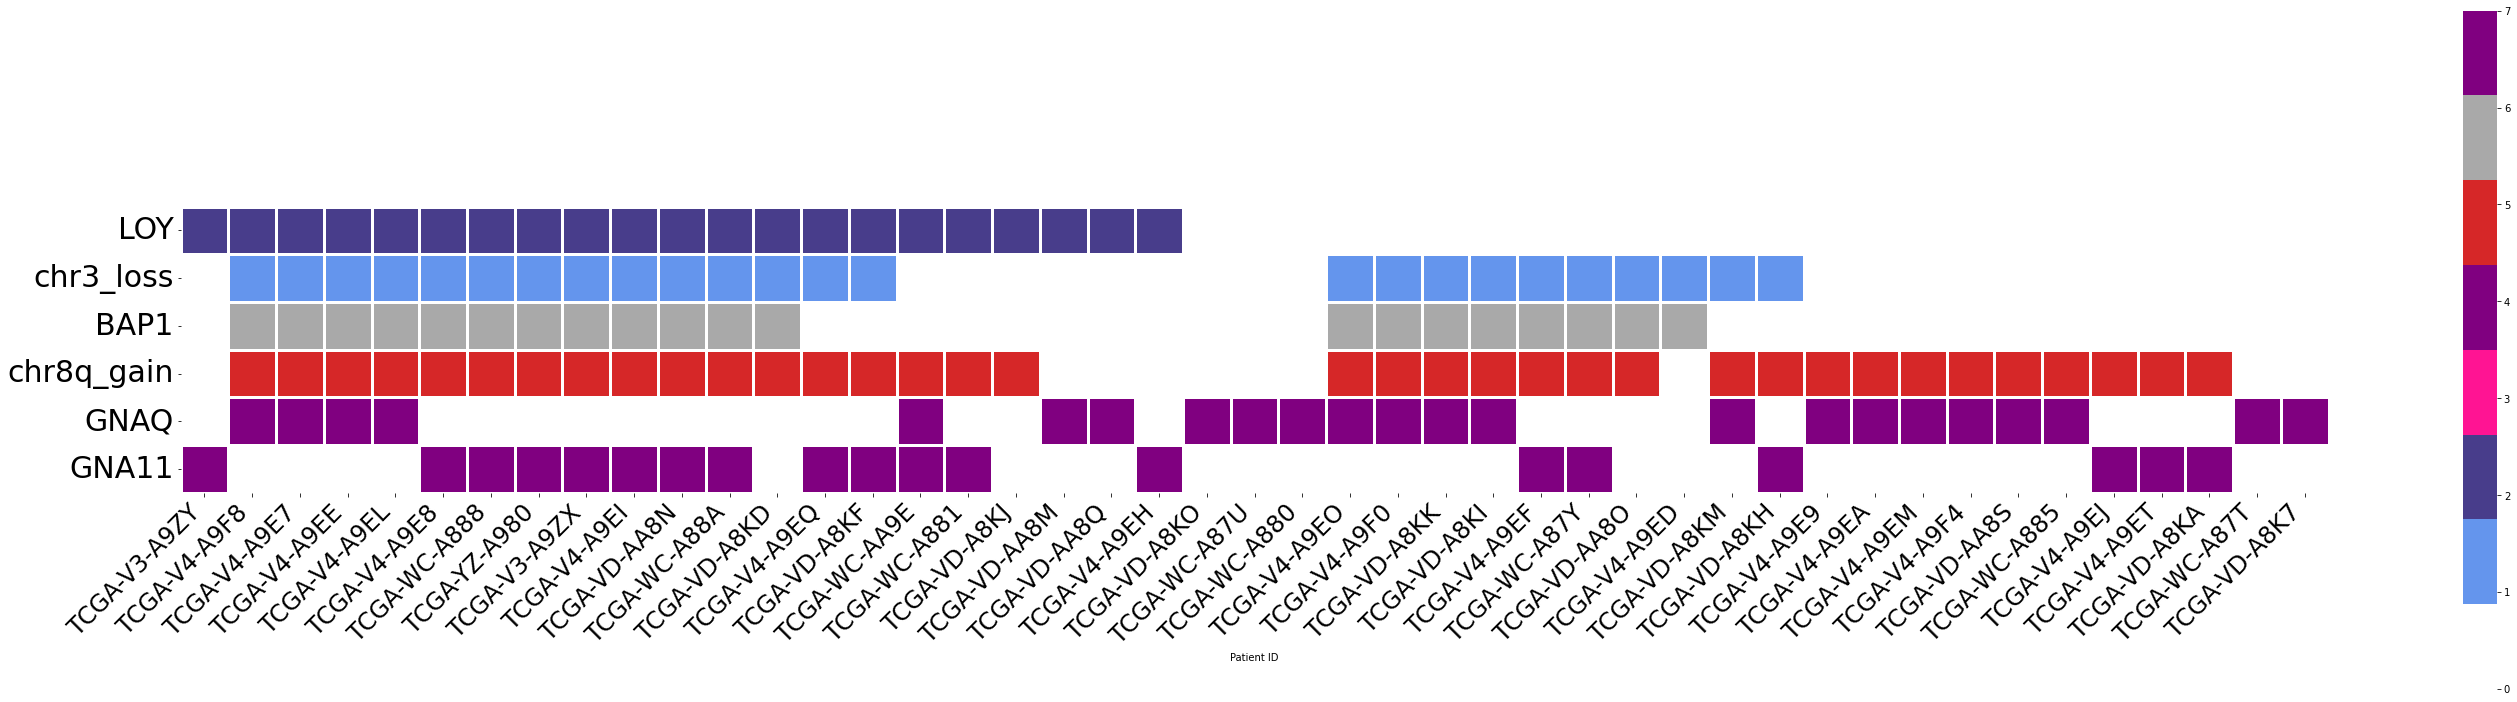

In [26]:
# Figure 5G
# comut with TCGA alterations and chrY
import matplotlib
warnings.filterwarnings('ignore')

UVM_subtypes['chr3_loss'] = UVM_subtypes.apply(lambda x: 1 if (re.search('LOH', str(x['3 CN (ABSOLUTE)'])) or int(x['3 CN (ABSOLUTE)']) <2) else 0, axis=1)
UVM_subtypes['chr8q_gain'] = UVM_subtypes.apply(lambda x: 1 if (int(x['8q CN (ABSOLUTE)']) >2) else 0, axis=1)
UVM_subtypes['BAP1_coded'] = UVM_subtypes.apply(lambda x: 0 if pd.isnull(x.BAP1) else 1, axis=1)

comut_data = UVM_subtypes
comut_data_males = comut_data[comut_data.Gender=='Male']


comut_binned = comut_data_males[['EIF1AX', 'Y_status', 'chr3_loss', 'chr8q_gain', 'GNAQ' ,'GNA11' ,'BAP1']]

comut_binned['EIF1AX'] = comut_binned.apply(lambda x: 0 if pd.isnull(x['EIF1AX']) else 4, axis=1)
comut_binned['chr8q_gain'] = comut_binned.apply(lambda x: 5 if x.chr8q_gain==1 else 0, axis=1)
comut_binned['BAP1'] = comut_binned.apply(lambda x: 0 if pd.isnull(x['BAP1']) else 6, axis=1)
comut_binned['GNAQ'] = comut_binned.apply(lambda x: 0 if pd.isnull(x.GNAQ) else 7, axis=1)
comut_binned['GNA11'] = comut_binned.apply(lambda x: 0 if pd.isnull(x.GNA11) else 8, axis=1)
comut_binned['LOY'] = comut_binned.apply(lambda x: 2 if x.Y_status=='LOY' else 0, axis=1)
#comut_binned['LOX'] = comut_binned.apply(lambda x: 3 if x.X_status=='LOX' else 0, axis=1)
comut_binned.sort_values(by=['LOY', 'EIF1AX', 'chr3_loss', 'BAP1', 'chr8q_gain', 'GNAQ', 'GNA11'], inplace=True, ascending=False)


fig, ax = plt.subplots(figsize=(40, 10))
sns.heatmap(comut_binned[['LOY', 'chr3_loss', 'BAP1', 'chr8q_gain', 'GNAQ', 'GNA11']].transpose(), cmap=matplotlib.colors.ListedColormap(['white', 'cornflowerblue', 'darkslateblue', 'deeppink' , 'purple', 'tab:red', 'darkgrey', 'purple']), linewidths=2.5, square=True, annot_kws={"size": 10}, vmin=0, vmax=7)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 24, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30, rotation=0, ha='right')
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_comut.pdf')


In [27]:
# Association with BAP1 mutations
df = comut_binned[['Y_status','BAP1']].value_counts()
print(df.unstack().loc[['LOY', 'wt_male']])
print ('Fisher p for LOY/wt_male and BAP1:', fisher_exact(df.unstack().loc[['LOY', 'wt_male']])[1])


BAP1       0   6
Y_status        
LOY        9  12
wt_male   16   8
Fisher p for LOY/wt_male and BAP1: 0.13966340176340947


In [28]:
# Association with chr8q_gain
df = comut_binned[['Y_status','chr8q_gain']].value_counts()
print(df.unstack().loc[['LOY', 'wt_male']])
print ('Fisher p for LOY/wt_male and chr8q_gain:', fisher_exact(df.unstack().loc[['LOY', 'wt_male']])[1])


chr8q_gain  0   5
Y_status         
LOY         4  17
wt_male     6  18
Fisher p for LOY/wt_male and chr8q_gain: 0.7288830346119056


In [29]:
# Association with chr3_loss
df = comut_binned[['Y_status','chr3_loss']].value_counts()
print(df.unstack().loc[['LOY', 'wt_male']])
print ('Fisher p for LOY/wt_male and chr3_loss:', fisher_exact(df.unstack().loc[['LOY', 'wt_male']])[1])


chr3_loss   0   1
Y_status         
LOY         7  14
wt_male    14  10
Fisher p for LOY/wt_male and chr3_loss: 0.1363059906483399


In [30]:
# Association with GNA11 mutations
df = comut_binned[['Y_status','GNA11']].value_counts()
print(df.unstack().loc[['LOY', 'wt_male']])
print ('Fisher p for LOY/wt_male and GNA11:', fisher_exact(df.unstack().loc[['LOY', 'wt_male']])[1])


GNA11      0   8
Y_status        
LOY        8  13
wt_male   18   6
Fisher p for LOY/wt_male and GNA11: 0.017154926333019748


In [31]:
#association with EIF1AX mutations 
#EIF1AX_mut = UVM_subtypes[~UVM_subtypes.EIF1AX.isnull()].index.values
#EIF1AX_fisher_male = fisher_exact([[len([x for x in LOY_cases if x in EIF1AX_mut]), len([x for x in UVM_low_Y if x not in EIF1AX_mut])],[len([x for x in UVM_male_other if x in EIF1AX_mut]), len([x for x in UVM_male_other if x not in EIF1AX_mut])]])
#print ("Association of fLOY with EIF1AX mutation (Fisher's exact):", EIF1AX_fisher_male)

df = comut_binned[['Y_status','EIF1AX']].value_counts()
print(df.unstack().loc[['LOY', 'wt_male']])
print ('Fisher p for LOY/wt_male and EIF1AX:', fisher_exact(df.unstack().loc[['LOY', 'wt_male']])[1])


EIF1AX     0  4
Y_status       
LOY       20  1
wt_male   21  3
Fisher p for LOY/wt_male and EIF1AX: 0.6109936575052864


In [32]:
# in official UVM MAF from TCGA UVM paper, TCGA-V4-A9EA has a DDX3Y missense mutation; this one is a wt sample

<h3> Survival analysis including other predictors </h3>

<lifelines.CoxPHFitter: fitted with 44 total observations, 25 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS_status'
      baseline estimation = breslow
   number of observations = 44
number of events observed = 19
   partial log-likelihood = -44.05
         time fit was run = 2022-08-31 11:34:17 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
chr8q_gain   0.97       2.63       1.10            -1.20             3.13                 0.30                22.81
Y_status     1.38       3.98       0.56             0.28             2.48                 1.32                11.93
BAP1_coded   1.33       3.77       0.62             0.10             2.55                 1.11                12.79

              z    p   -log2(p)
covariate                      
chr8q_gain 0.88 0.38       1.39
Y_status   2.46 0.01       6.17
BAP1_coded 2.13 0.03       4.90
---
Concordance = 0.83
Partial AIC = 94.10
log-likelihood ratio test = 20.85 on 3 df
-log2(p) of ll-ratio test = 13.11

<lifelines.CoxPHFitter: fitted with 44 total observations, 25 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS_status'
      baseline estimation = breslow
   number of observations = 44
number of events observed = 19
   partial log-likelihood = -44.05
         time fit was run = 2022-08-31 11:34:17 UTC

---
            exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                           
chr8q_gain       2.63                 0.30                22.81 0.38
Y_status         3.98                 1.32                11.93 0.01
BAP1_coded       3.77                 1.11                12.79 0.03
---
Concordance = 0.83
Partial AIC = 94.10
log-likelihood ratio test = 20.85 on 3 df
-log2(p) of ll-ratio test = 13.11

            exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%         p
covariate                                                                
chr8q_gain   2.626341             0.302397            22.809988  0.381292
Y_status     3.975806             1.324570            11.933706  0.013848
BAP1_coded   3.768040             1.109953            12.791651  0.033400


<lifelines.CoxPHFitter: fitted with 44 total observations, 25 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS_status'
      baseline estimation = breslow
   number of observations = 44
number of events observed = 19
   partial log-likelihood = -41.65
         time fit was run = 2022-08-31 11:34:17 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Y_status     1.47       4.36       0.58             0.33             2.61                 1.39                13.66
BAP1_coded  -0.45       0.64       0.79            -2.00             1.09                 0.14                 2.99
chr3_loss    2.54      12.71       1.10             0.39             4.69                 1.48               108.80
chr8q_gain   0.39       1.47       1.16            -1.89             2.66                 0.15                14.29

               z    p   -log2(p)
covariate                       
Y_status    2.53 0.01       6.45
BAP1_coded -0.57 0.57       0.82
chr3_loss   2.32 0.02       5.62
chr8q_gain  0.33 0.74       0.44
---
Concordance = 0.86
Partial AIC = 91.31
log-likelihood ratio test = 25.64 on 4 df
-log2(p) of ll-ratio test = 14.71

<lifelines.CoxPHFitter: fitted with 44 total observations, 25 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS_status'
      baseline estimation = breslow
   number of observations = 44
number of events observed = 19
   partial log-likelihood = -41.65
         time fit was run = 2022-08-31 11:34:17 UTC

---
            exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%    p
covariate                                                           
Y_status         4.36                 1.39                13.66 0.01
BAP1_coded       0.64                 0.14                 2.99 0.57
chr3_loss       12.71                 1.48               108.80 0.02
chr8q_gain       1.47                 0.15                14.29 0.74
---
Concordance = 0.86
Partial AIC = 91.31
log-likelihood ratio test = 25.64 on 4 df
-log2(p) of ll-ratio test = 14.71

            exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%         p
covariate                                                                
Y_status     4.361924             1.393354            13.655097  0.011417
BAP1_coded   0.636129             0.135452             2.987472  0.566517
chr3_loss   12.705284             1.483719           108.797072  0.020337
chr8q_gain   1.471955             0.151588            14.293003  0.738890


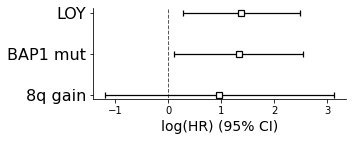

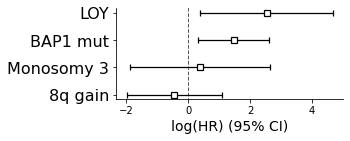

In [33]:
# Figure 5H
# cox regression for LOY and other known predictors of expression in UVM
cph = CoxPHFitter()

# CoxPHFitter takes one dataframe with covariates and survival information
# some dataframe preprocessing - adding survival columns, coding of non-numerical variables
cph_pfs_males = UVM_subtypes.loc[[x for x in UVM_subtypes.index.values if x in males]]
cph_pfs_males['Y_status'] = cph_pfs_males.apply(lambda x: 1 if x.name in LOY_cases else 0, axis=1)

cph_pfs = cph_pfs_males[['Age at Diagnosis','chr3_loss', 'chr8q_gain', 'Y_status', 'BAP1_coded']]
cph_pfs['PFS.time'] = cph_pfs.apply(lambda x: TCGA_survival.loc[x.name]['PFS.time'], axis=1)
cph_pfs['PFS_status'] = cph_pfs.apply(lambda x: TCGA_survival.loc[x.name]['PFS'], axis=1)

# multivariate model to predict OS
cph_pfs = cph_pfs_males[[ 'chr8q_gain', 'Y_status', 'BAP1_coded']]
#cph_pfs = cph_pfs_males[['chr8q_gain', 'Y_status', 'chr3_loss']]
cph_pfs['PFS.time'] = cph_pfs.apply(lambda x: TCGA_survival.loc[x.name]['PFS.time'], axis=1)
cph_pfs['PFS_status'] = cph_pfs.apply(lambda x: TCGA_survival.loc[x.name]['PFS'], axis=1)
cph.fit(cph_pfs.dropna(), duration_col='PFS.time', event_col='PFS_status')
cph.print_summary()
# fewer columns for figure
cph.print_summary(columns = ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p'])
# explicitely setting hazard_ratios=True shows hazard ratios vs. log hazards 
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
cph.plot(hazard_ratios=False)
plt.yticks(ticks = [2,1,0], labels = ['LOY', 'BAP1 mut', '8q gain'], fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
print (cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']])
plt.tight_layout()
plt.xlabel('log(HR) (95% CI)', fontsize=14)
plt.savefig(fig_dir + 'UVM_CoxPH_forest.pdf')

# multivariate model to predict PFS
cph_pfs = cph_pfs_males[[ 'Y_status', 'BAP1_coded', 'chr3_loss',  'chr8q_gain']]
cph_pfs['PFS.time'] = cph_pfs.apply(lambda x: TCGA_survival.loc[x.name]['PFS.time'], axis=1)
cph_pfs['PFS_status'] = cph_pfs.apply(lambda x: TCGA_survival.loc[x.name]['PFS'], axis=1)
cph.fit(cph_pfs.dropna(), duration_col='PFS.time', event_col='PFS_status')
cph.print_summary()
# fewer columns for figure
cph.print_summary(columns = ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p'])
# explicitly setting hazard_ratios=True shows hazard ratios vs. log hazards 
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
cph.plot(hazard_ratios=False)
plt.yticks(ticks = [3,2,1,0], labels = ['LOY', 'BAP1 mut', 'Monosomy 3', '8q gain',], fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
print (cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']])
plt.tight_layout()
plt.xlabel('log(HR) (95% CI)', fontsize=14)
plt.savefig(fig_dir +'UVM_multivariate_forest.pdf')

<h2> Differential gene expression between LOY and wt UVM cases <h2>

In [34]:
# TCGA pancan expression data
# gene expression from pancan atlas: http://api.gdc.cancer.gov/data/3586c0da-64d0-4b74-a449-5ff4d9136611
TCGA_pancan_exp = pd.read_csv('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']


# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]

#stype = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x or '-06A-' in x) else 'normal' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]


In [35]:
# Subset to males and females
common_males = list(set(tumor_exp_unique.columns.values).intersection(set(males)))
common_females = list(set(tumor_exp_unique.columns.values).intersection(set(females)))
tumor_exp_unique_males = tumor_exp_unique[common_males]
tumor_exp_unique_females = tumor_exp_unique[common_females]

In [36]:
# Differential gene expression between lowY and other samples in UVM
warnings.filterwarnings('ignore')

UVM_exp= tumor_exp_unique[[x for x in UVM_clinical.index if x in tumor_exp_unique.columns]]
UVM_exp_males = UVM_exp[[x for x in UVM_exp.columns if x in UVM_clinical[UVM_clinical.Gender=='Male'].index]]

UVM_diff_exp_pvalues = pd.DataFrame(index = UVM_exp_males.index.values, columns = ['ttest_p_LOY', 'avg_LOY', 'avg_wtY'])
UVM_diff_exp_pvalues = UVM_diff_exp_pvalues.fillna(np.nan)

for g in UVM_exp.index.values:  
    if g =="?":
        continue
    g_LOY = UVM_exp.loc[g][set(LOY_cases) & set(UVM_exp.columns.values)].dropna()
    g_wtY = UVM_exp.loc[g][set(wtY_cases) & set(UVM_exp.columns.values)].dropna()

    if len(g_LOY)<=3 or len(g_wtY) <=3:
        continue

    UVM_diff_exp_pvalues.loc[g]['ttest_p_LOY'] = ttest_ind(g_LOY, g_wtY, equal_var=False, nan_policy='omit')[1]
    UVM_diff_exp_pvalues.loc[g]['avg_LOY'] = np.nanmean(g_LOY)
    UVM_diff_exp_pvalues.loc[g]['avg_wtY'] = np.nanmean(g_wtY)


In [37]:
# calculate some more values - LOY
UVM_diff_exp_pvalues = UVM_diff_exp_pvalues.dropna()

# add pseudocounts to fold diff calculation to avoid zero float division error
UVM_diff_exp_pvalues['fold_diff_LOY'] = UVM_diff_exp_pvalues.apply(lambda x: float(x.avg_LOY+0.01)/float(x.avg_wtY+0.01), axis=1) 
UVM_diff_exp_pvalues['log2_fold_diff_LOY'] = UVM_diff_exp_pvalues.apply(lambda x: np.log2(x.fold_diff_LOY), axis=1)

UVM_diff_exp_pvalues['q_value_LOY']=fdrcorrection(UVM_diff_exp_pvalues.ttest_p_LOY)[1]
UVM_diff_exp_pvalues.sort_values(by='q_value_LOY', inplace=True)
UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1]


,ttest_p_LOY,avg_LOY,avg_wtY,fold_diff_LOY,log2_fold_diff_LOY,q_value_LOY
KDM5D,5.969768e-14,55.668362,1072.069174,0.051935,-4.267151,1.153001e-09
RPS4Y1,1.118348e-12,224.992876,11917.663913,0.018880,-5.727015,1.079988e-08
SFRS17A,2.894298e-09,489.379429,887.321913,0.551529,-0.858491,1.863349e-05
UTY,4.345135e-09,12.920033,358.506087,0.036065,-4.793240,2.098049e-05
ZBED1,1.364432e-08,1216.922619,2158.044348,0.563903,-0.826482,5.189368e-05
DDX3Y,1.880790e-08,58.126881,908.849565,0.063967,-3.966532,5.189368e-05
TTTY15,1.642603e-08,8.106438,149.771752,0.054188,-4.205871,5.189368e-05
TTTY14,1.924871e-07,0.052871,11.902396,0.005278,-7.565843,4.647120e-04
EIF1AY,3.451548e-07,18.432490,486.150665,0.037935,-4.720328,7.407022e-04
TMSB4Y,5.627772e-07,2.132105,32.574448,0.065740,-3.927083,1.086948e-03


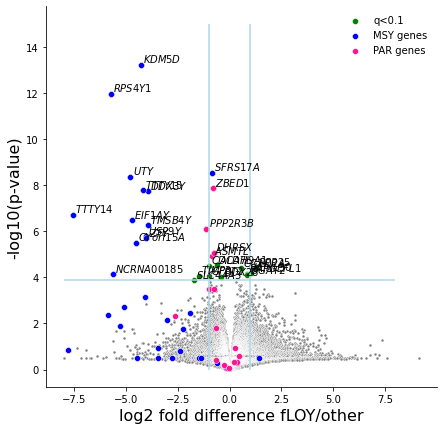

In [38]:
# Figure 5I
# volcano plot- log2FD vs log10 p-value
# only use genes that are in expression data
# CYorf15A is TXLNGY 
# is NCRNA00185 is TTTY14
exp_Y_genes = [x for x in chrY_genes if x in UVM_diff_exp_pvalues.index]+['CYorf15A', 'NCRNA00185', 'SFRS17A']
exp_par_genes = [x for x in par_genes if x in UVM_diff_exp_pvalues.index]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x = UVM_diff_exp_pvalues.log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues.ttest_p_LOY), color='grey', marker = '.', ax=ax)
sns.scatterplot(x = UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].ttest_p_LOY), color='green', label = 'q<0.1')
sns.scatterplot(x = UVM_diff_exp_pvalues.loc[exp_Y_genes].log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues.loc[exp_Y_genes].ttest_p_LOY), marker = 'o', color='blue', label = 'MSY genes')
sns.scatterplot(x = UVM_diff_exp_pvalues.loc[exp_par_genes].log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues.loc[exp_par_genes].ttest_p_LOY), marker = 'o', color='deeppink', label = 'PAR genes')

# indicate significance threshold
ax.hlines(-np.log10(np.max(UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].ttest_p_LOY)), -8,8, color = 'lightblue')
# lines for 2-fold up or down
ax.vlines(-np.log2(2), 0,15, color = 'lightblue')
ax.vlines(np.log2(2), 0,15, color = 'lightblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].iterrows():
    ax.text(row.log2_fold_diff_LOY+0.1, -np.log10(row.ttest_p_LOY)+0.1, '$\it{' + row.name + '}$')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('-log10(p-value)', fontsize=16)
ax.set_xlabel('log2 fold difference fLOY/other', fontsize=16)
plt.savefig(fig_dir + "TCGA_UVM_DE_volcano.pdf")

In [39]:
#UVM_diff_exp_pvalues.to_csv('/Users/esther/Documents/Projects/2019/chrY/Manuscript/UVM_diff_exp.tsv',sep='\t', header=True, index = True)

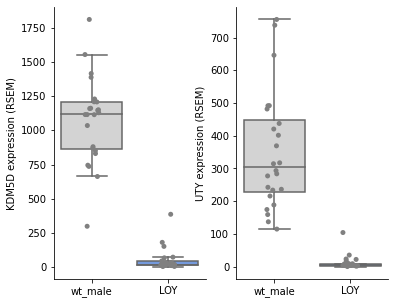

In [40]:
# Supplementary Figure 5C
g = 'KDM5D'
g_LOY = UVM_exp.loc[g][set(LOY_cases) & set(UVM_exp.columns.values)].dropna()
g_wtY = UVM_exp.loc[g][set(wtY_cases) & set(UVM_exp.columns.values)].dropna()

df = pd.DataFrame(UVM_exp_males.loc[g].transpose())
df['Y_status'] = df.apply(lambda x: UVM_subtypes.loc[x.name].Y_status, axis=1)

fig, ax = plt.subplots(1,2, figsize = (6,5))
sns.boxplot(x = 'Y_status', y = g, data = df, palette = ['lightgrey', 'cornflowerblue'], order=['wt_male', 'LOY'] ,ax=ax[0], fliersize=0)
sns.stripplot(x = 'Y_status', y = g, data = df, order=['wt_male', 'LOY'], color='grey', ax=ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('')
ax[0].set_ylabel(g + ' expression (RSEM)')           
           
g = 'UTY'
g_LOY = UVM_exp.loc[g][set(LOY_cases) & set(UVM_exp.columns.values)].dropna()
g_wtY = UVM_exp.loc[g][set(wtY_cases) & set(UVM_exp.columns.values)].dropna()

df = pd.DataFrame(UVM_exp_males.loc[g].transpose())
df['Y_status'] = df.apply(lambda x: UVM_subtypes.loc[x.name].Y_status, axis=1)

sns.boxplot(x = 'Y_status', y = g, data = df, palette = ['lightgrey', 'cornflowerblue'], order=['wt_male', 'LOY'], ax=ax[1], fliersize=0)
sns.stripplot(x = 'Y_status', y = g, data = df, order=['wt_male', 'LOY'], color='grey', ax=ax[1])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('')
ax[1].set_ylabel(g + ' expression (RSEM)')           
plt.savefig(fig_dir + 'UVM_KDM5D_UTY_distributions.pdf')      


In [41]:
# Jiali Pang's LOY classification table from Durante et al, 2020 dataset
uvm_sc_Durante = pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/UVM/single_cells/Durante_GSE139829/Jiali_Durante_uvm_pred.csv', sep=',', header=0, index_col=0)

In [42]:
uvm_sc_Durante['total_cells'] = uvm_sc_Durante.apply(lambda x: uvm_sc_Durante[uvm_sc_Durante['orig.ident'] == x['orig.ident']]['orig.ident'].count(), axis=1)


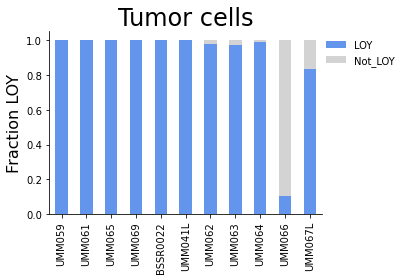

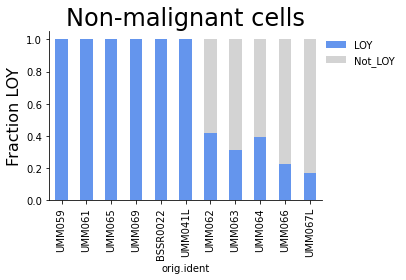

In [43]:
# Figure 5J
Durante_tumor_cells  = uvm_sc_Durante[['orig.ident', 'super_cell' ,'loy_pred' ]].groupby('orig.ident').value_counts()

# plot order: female primary first, then female met, then male primary, male met
order = ['UMM059', 'UMM061', 'UMM065', 'UMM069',  'BSSR0022','UMM041L',  'UMM062', 'UMM063', 'UMM064', 'UMM066', 'UMM067L']
Durante_tumor_cells = uvm_sc_Durante[uvm_sc_Durante.super_cell=='Tumor cells']
Durante_tumor_cells_grouped = (Durante_tumor_cells.groupby('orig.ident')['loy_pred'].value_counts()/Durante_tumor_cells.groupby('orig.ident')['loy_pred'].count()).unstack()
Durante_tumor_cells_grouped.loc[order].plot(kind='bar', stacked='True', color = {'LOY':'cornflowerblue', 'Not_LOY':'lightgrey'})
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Fraction LOY', fontsize=16)
plt.title('Tumor cells', fontsize=24)
plt.xlabel('')
plt.tight_layout()
plt.savefig(workdir + 'Durante_SC_tumor_cells.pdf')

# because there are relatively few, aggregate all non-malignant cells
Durante_nonmalignant_cells = uvm_sc_Durante[uvm_sc_Durante.super_cell!='Tumor cells']
Durante_nonmalignant_cells_grouped = (Durante_nonmalignant_cells.groupby('orig.ident')['loy_pred'].value_counts()/Durante_nonmalignant_cells.groupby('orig.ident')['loy_pred'].count()).unstack()
Durante_nonmalignant_cells_grouped.loc[order].plot(kind='bar', stacked='True', color = {'LOY':'cornflowerblue', 'Not_LOY':'lightgrey'})
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Fraction LOY', fontsize=16)
plt.title('Non-malignant cells', fontsize=24)
plt.tight_layout()
plt.savefig(fig_dir + 'Durante_SC_nonmalignant_cells.pdf')

    

<h3> Association of LOX with distant metastasis </h3>

LOX/metastasis Fisher p: (0.20168067226890757, 0.06191222570532917)
46.666666666666664 % of LOX cases metastasized vs 15.0 % of wt cases


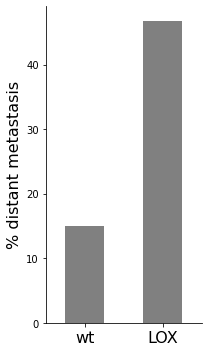

In [44]:
# Female LOX calls
WEX_calls_female = pd.read_excel('/Users/esther/Documents/Projects/2019/chrY/TCGA_WEX/Supplementary_tables.xlsx', sheet_name='Supp_Table_2', header=0, index_col=0)

LOX_cases = WEX_calls_female[(WEX_calls_female.Gender=='female') & (WEX_calls_female.X_status=='LOX')].index
wtX_cases = WEX_calls_female[(WEX_calls_female.Gender=='female') & (WEX_calls_female.X_status=='WT')].index

TCGA_sample_info['LOX_status'] = TCGA_sample_info.apply(lambda x: WEX_calls_female.loc[x.name].X_status if x.name in WEX_calls_female.index else np.nan, axis=1)

UVM_clinical['X_status'] = UVM_clinical.apply(lambda x: 'LOX' if (x.name in females and x.name in LOX_cases) else ('wt_female' if x.name in females else 'NA'), axis=1)
UVM_subtypes['X_status'] = UVM_subtypes.apply(lambda x: 'LOX' if (x.name in females and x.name in LOX_cases) else ('wt_female' if x.name in females else 'NA'), axis=1)

# Supplementary Figure 5E
df = UVM_clinical[UVM_clinical.Gender=='Female'].groupby('X_status')['Distant Metastasis'].value_counts().unstack()
met_fisher = fisher_exact(df.loc[['LOX', 'wt_female']])
print('LOX/metastasis Fisher p:', met_fisher)
print(7/15*100, '% of LOX cases metastasized vs', 3/20*100, '% of wt cases' )
df.fraction = df.Yes/(df.Yes+df.No)*100
plt.figure(figsize=(3,5)) 
df.fraction[['wt_female', 'LOX']].plot(kind='bar', color='grey')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% distant metastasis', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('')
plt.xticks([0,1], labels=['wt', 'LOX'], rotation = 0, fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_distant_met_barplot_LOX.pdf')